In [2]:
%cd ..

d:\github\ripple_heterogeneity\python


In [18]:
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import hdf5storage
import h5py
import scipy.io as sio

import sys,os

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

from scipy.ndimage import gaussian_filter1d

import math
from scipy import stats
from pathlib import Path
import seaborn as sns

# default figure params

In [4]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'

In [5]:
class ISI_analysis:
    def __init__(self,xmin=0,xmax=0.100,binwidth=0.001,ripple_freq=1/200):
        self.xmin = xmin
        self.xmax = xmax
        self.binwidth = binwidth
        self.ripple_freq = ripple_freq

    def bin_data(self,data):
        bins = np.arange(self.xmin,self.xmax+self.binwidth,self.binwidth)

        hist, _ = np.histogram(data,bins=bins)
        # hist = hist/hist.sum()
        hist = stats.zscore(hist)
        return hist

    def peak_cycle_time(self,isi_,cycle_num=1):

        bin_center = np.arange(self.xmin,self.xmax,self.binwidth) + self.binwidth
        idx = (bin_center >= self.ripple_freq*(cycle_num-1)) & (bin_center <= self.ripple_freq*cycle_num)

        cycle_ts = bin_center[idx]

        return cycle_ts[np.argmax(isi_[idx])]

    def peak_cycle_val(self,isi_,cycle_num=1):

        bin_center = np.arange(self.xmin,self.xmax,self.binwidth) + self.binwidth
        idx = (bin_center >= self.ripple_freq*(cycle_num-1)) & (bin_center <= self.ripple_freq*cycle_num)

        return np.max(isi_[idx])

    def first_second_isi_ratio(self,isi_):
        n_isi_cycle_1 = np.sum((isi_> 0) & (isi_ < self.ripple_freq))
        n_isi_cycle_2 = np.sum((isi_ > self.ripple_freq) & (isi_ < self.ripple_freq*2))
        return n_isi_cycle_1 / n_isi_cycle_2 

# main analysis

In [8]:
def run_all_isi_features(sessions,groups):
    # make default params
    isi = ISI_analysis()

    # create empty vars 
    mean_isi = np.zeros((len(sessions),3))
    peak_ts_first_cycle = np.zeros_like(mean_isi)
    peak_ts_second_cycle = np.zeros_like(mean_isi)
    peak_val_first_cycle = np.zeros_like(mean_isi)
    peak_val_second_cycle = np.zeros_like(mean_isi)
    peak_val_norm_first_cycle = np.zeros_like(mean_isi)
    peak_val_norm_second_cycle = np.zeros_like(mean_isi)
    first_second_isi_ratio = np.zeros_like(mean_isi)

    bin_center = np.arange(isi.xmin,isi.xmax,isi.binwidth) + isi.binwidth
    all_deep_isi = np.zeros((len(sessions),len(bin_center)))
    all_sup_isi = np.zeros_like(all_deep_isi)
    all_deep_sup_isi = np.zeros_like(all_deep_isi)

    for i,basepath in enumerate(sessions):
        # print(basepath)
        isi_df = pd.read_csv(basepath)

        # mean isi
        mean_isi[i,:] = [np.mean(isi_df[groups[0]]),
                        np.mean(isi_df[groups[1]]),
                        np.mean(isi_df[groups[2]])]

        # make ISI dist
        deep_isi = isi.bin_data(isi_df[groups[0]])
        sup_isi = isi.bin_data(isi_df[groups[1]])
        deep_sup_isi = isi.bin_data(isi_df[groups[2]])
        
        # store isi
        all_deep_isi[i,:] = deep_isi
        all_sup_isi[i,:] = sup_isi
        all_deep_sup_isi[i,:] = deep_sup_isi

        # max ts of first peak
        peak_ts_first_cycle[i,:] = [isi.peak_cycle_time(deep_isi),
                                    isi.peak_cycle_time(sup_isi),
                                    isi.peak_cycle_time(deep_sup_isi)]
        # max ts of second peak
        peak_ts_second_cycle[i,:] = [isi.peak_cycle_time(deep_isi,cycle_num=2),
                                    isi.peak_cycle_time(sup_isi,cycle_num=2),
                                    isi.peak_cycle_time(deep_sup_isi,cycle_num=2)]

        # max of first peak
        peak_val_first_cycle[i,:] = [isi.peak_cycle_val(deep_isi),
                                    isi.peak_cycle_val(sup_isi),
                                    isi.peak_cycle_val(deep_sup_isi)]
        # max of second peak
        peak_val_second_cycle[i,:] = [isi.peak_cycle_val(deep_isi,cycle_num=2),
                                    isi.peak_cycle_val(sup_isi,cycle_num=2),
                                    isi.peak_cycle_val(deep_sup_isi,cycle_num=2)]

        # max of first peak normed
        peak_val_norm_first_cycle[i,:] = [isi.peak_cycle_val(deep_isi - gaussian_filter1d(deep_isi, 5)),
                                    isi.peak_cycle_val(sup_isi - gaussian_filter1d(sup_isi, 5)),
                                    isi.peak_cycle_val(deep_sup_isi - gaussian_filter1d(deep_sup_isi, 5))]
        # max of second peak normed
        peak_val_norm_second_cycle[i,:] = [isi.peak_cycle_val(deep_isi - gaussian_filter1d(deep_isi, 5),cycle_num=2),
                                    isi.peak_cycle_val(sup_isi - gaussian_filter1d(sup_isi, 5),cycle_num=2),
                                    isi.peak_cycle_val(deep_sup_isi - gaussian_filter1d(deep_sup_isi, 5),cycle_num=2)]    

        # get ratio of ISIs between the first and second ripple cycle
        first_second_isi_ratio[i,:] = [isi.first_second_isi_ratio(isi_df[groups[0]]),
                                    isi.first_second_isi_ratio(isi_df[groups[1]]),
                                    isi.first_second_isi_ratio(isi_df[groups[2]])]

    df = pd.DataFrame()
    basepath = [Path(basepath).stem for basepath in sessions]
    df['basepath'] = np.hstack([basepath,basepath,basepath])
    df['group'] = [groups[0]]*len(mean_isi[:,0]) + [groups[1]]*len(mean_isi[:,0]) + [groups[2]]*len(mean_isi[:,0])
    df['mean_isi'] = np.hstack([mean_isi[:,0],mean_isi[:,1],mean_isi[:,2]])
    df['peak_ts_first_cycle'] = np.hstack([peak_ts_first_cycle[:,0],peak_ts_first_cycle[:,1],peak_ts_first_cycle[:,2]])
    df['peak_ts_second_cycle'] = np.hstack([peak_ts_second_cycle[:,0],peak_ts_second_cycle[:,1],peak_ts_second_cycle[:,2]])
    df['peak_val_first_cycle'] = np.hstack([peak_val_first_cycle[:,0],peak_val_first_cycle[:,1],peak_val_first_cycle[:,2]])
    df['peak_val_second_cycle'] = np.hstack([peak_val_second_cycle[:,0],peak_val_second_cycle[:,1],peak_val_second_cycle[:,2]])
    df['peak_val_norm_first_cycle'] = np.hstack([peak_val_norm_first_cycle[:,0],peak_val_norm_first_cycle[:,1],peak_val_norm_first_cycle[:,2]])
    df['peak_val_norm_second_cycle'] = np.hstack([peak_val_norm_second_cycle[:,0],peak_val_norm_second_cycle[:,1],peak_val_norm_second_cycle[:,2]])
    df['first_second_isi_ratio'] = np.hstack([first_second_isi_ratio[:,0],first_second_isi_ratio[:,1],first_second_isi_ratio[:,2]])
    
    return df,all_deep_isi,all_sup_isi,all_deep_sup_isi

# run above analysis 

In [11]:
groups = ["Deep","Superficial","DeepSuperficial"]

# sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_deep_sup\*.csv')
# df,all_deep_isi,all_sup_isi,all_deep_sup_isi = run_all_isi_features(sessions,groups)

# sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_deep_sup_rip_dur_80ms\pre\*.csv')
# df_pre,all_deep_isi_pre,all_sup_isi_pre,all_deep_sup_isi_pre = run_all_isi_features(sessions,groups)

# sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_deep_sup_rip_dur_80ms\task\*.csv')
# df_task,all_deep_isi_task,all_sup_isi_task,all_deep_sup_isi_task = run_all_isi_features(sessions,groups)

# sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_deep_sup_rip_dur_80ms\post\*.csv')
# df_post,all_deep_isi_post,all_sup_isi_post,all_deep_sup_isi_post = run_all_isi_features(sessions,groups)


groups = ["low_particip","high_particip","low_participhigh_particip"]

sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_low_high_partic\pre\*.csv')
df_pre,all_deep_isi_pre,all_sup_isi_pre,all_deep_sup_isi_pre = run_all_isi_features(sessions,groups)

sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_low_high_partic\task\*.csv')
df_task,all_deep_isi_task,all_sup_isi_task,all_deep_sup_isi_task = run_all_isi_features(sessions,groups)

sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_low_high_partic\post\*.csv')
df_post,all_deep_isi_post,all_sup_isi_post,all_deep_sup_isi_post = run_all_isi_features(sessions,groups)

# For pre/task/post comparison, make sure the session line up over epochs

In [13]:
# check if session does not exist in all epochs
# groups = ["deep","sup","deep_sup"]
groups = ["low_particip","high_particip","low_participhigh_particip"]

basepaths = pd.unique(np.hstack([df_pre.basepath,df_task.basepath,df_post.basepath]))
keep = []
for basepath in basepaths:
    keep.append(
                np.any(df_pre[df_pre.group==groups[0]].basepath == basepath) &
                np.any(df_task[df_task.group==groups[0]].basepath == basepath) &
                np.any(df_post[df_post.group==groups[0]].basepath == basepath)
                )

for basepath in basepaths[list(~np.array(keep))]:

    idx = df_pre[df_pre.group==groups[0]].basepath == basepath
    all_deep_isi_pre = np.delete(all_deep_isi_pre, np.where(idx), 0)

    idx = df_task[df_task.group==groups[0]].basepath == basepath
    all_deep_isi_task = np.delete(all_deep_isi_task, np.where(idx), 0)

    idx = df_post[df_post.group==groups[0]].basepath == basepath
    all_deep_isi_post = np.delete(all_deep_isi_post, np.where(idx), 0)


    idx = df_pre[df_pre.group==groups[1]].basepath == basepath
    all_sup_isi_pre = np.delete(all_sup_isi_pre, np.where(idx), 0)

    idx = df_task[df_task.group==groups[1]].basepath == basepath
    all_sup_isi_task = np.delete(all_sup_isi_task, np.where(idx), 0)

    idx = df_post[df_post.group==groups[1]].basepath == basepath
    all_sup_isi_post = np.delete(all_sup_isi_post, np.where(idx), 0)


    idx = df_pre[df_pre.group==groups[2]].basepath == basepath
    all_deep_sup_isi_pre = np.delete(all_deep_sup_isi_pre, np.where(idx), 0)

    idx = df_task[df_task.group==groups[2]].basepath == basepath
    all_deep_sup_isi_task = np.delete(all_deep_sup_isi_task, np.where(idx), 0)

    idx = df_post[df_post.group==groups[2]].basepath == basepath
    all_deep_sup_isi_post = np.delete(all_deep_sup_isi_post, np.where(idx), 0)

    df_pre = df_pre.drop(df_pre.index[np.where(df_pre.basepath == basepath)])
    df_task = df_task.drop(df_task.index[np.where(df_task.basepath == basepath)])
    df_post = df_post.drop(df_post.index[np.where(df_post.basepath == basepath)])

df_pre.reset_index(drop=True,inplace=True)
df_task.reset_index(drop=True,inplace=True)
df_post.reset_index(drop=True,inplace=True)

# Overall feature plots

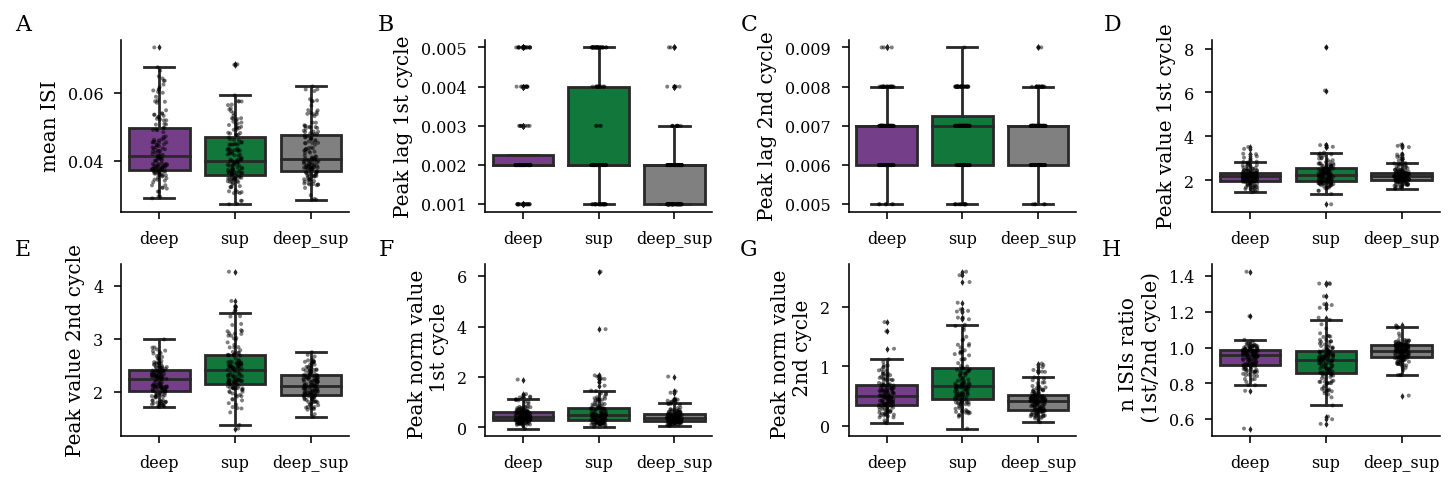

In [555]:
import seaborn as sns
def plot_the_box(df,x,y,group_colors,ax):
    sns.boxplot(x=x, y=y, data=df,fliersize=1,
                 ax=ax,hue_order=group_colors.keys())

    sns.stripplot(x=x, y=y, data=df,
                size=2, color="k", linewidth=0,ax=ax,
                alpha=.5,dodge=True,hue_order=group_colors.keys())


fig, axs = plt.subplots(2,4, figsize=functions.set_size('thesis', fraction=2, subplots=(2, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.6)
axs = axs.ravel()

group_colors= {"deep": '#7b3294',
                'sup': '#008837',
                'deep_sup': "grey"
                } 

sns.set_palette(sns.color_palette(group_colors.values()))

plot_the_box(df,"group","mean_isi",group_colors,axs[0])
plot_the_box(df,"group","peak_ts_first_cycle",group_colors,axs[1])
plot_the_box(df,"group","peak_ts_second_cycle",group_colors,axs[2])
plot_the_box(df,"group","peak_val_first_cycle",group_colors,axs[3])
plot_the_box(df,"group","peak_val_second_cycle",group_colors,axs[4])
plot_the_box(df,"group","peak_val_norm_first_cycle",group_colors,axs[5])
plot_the_box(df,"group","peak_val_norm_second_cycle",group_colors,axs[6])
plot_the_box(df,"group","first_second_isi_ratio",group_colors,axs[7])

for i in range(8):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].set_xlabel("")

axs[0].set_ylabel("mean ISI")
axs[1].set_ylabel("Peak lag 1st cycle")
axs[2].set_ylabel("Peak lag 2nd cycle")
axs[3].set_ylabel("Peak value 1st cycle")
axs[4].set_ylabel("Peak value 2nd cycle")
axs[5].set_ylabel("Peak norm value \n 1st cycle")
axs[6].set_ylabel("Peak norm value \n 2nd cycle")
axs[7].set_ylabel("n ISIs ratio \n (1st/2nd cycle)")

for i, label in enumerate(('A','B', 'C', 'D','E','F','G','H')):
    axs[i].text(-0.4, 1.15, label, transform=axs[i].transAxes,
      fontsize=11, fontweight='normal', va='top', ha='right')

plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_feature_boxplots.pdf'),dpi=300,bbox_inches='tight')


# Overall ISI plots

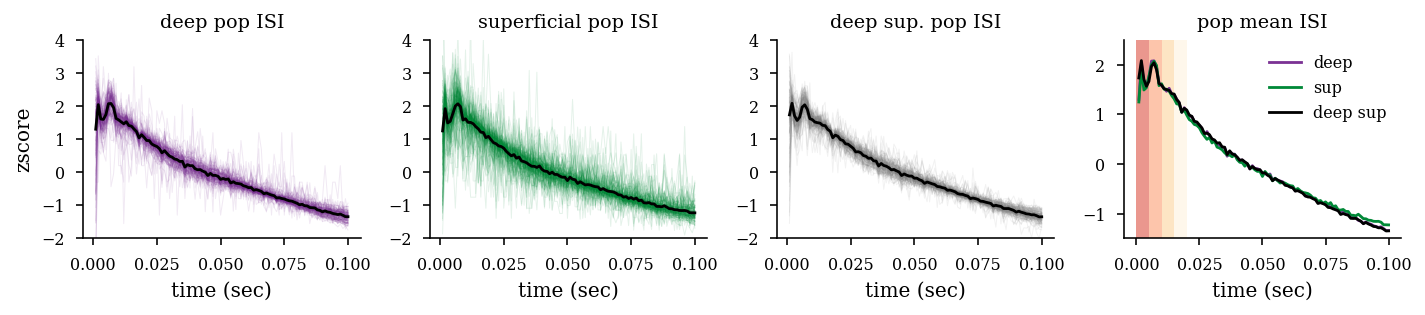

In [553]:
fig, axs = plt.subplots(1,4,figsize=functions.set_size('thesis', fraction=2, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.25)
axs = axs.ravel()

isi = ISI_analysis()
bin_center = np.arange(isi.xmin,isi.xmax,isi.binwidth) + isi.binwidth

axs[0].plot(bin_center,all_deep_isi.T,color="#7b3294",alpha=.1,linewidth=.5)
axs[0].plot(bin_center,np.nanmean(all_deep_isi,axis=0),color="k")

axs[1].plot(bin_center,all_sup_isi.T,color="#008837",alpha=.1,linewidth=.5)
axs[1].plot(bin_center,np.nanmean(all_sup_isi,axis=0),color="k")

axs[2].plot(bin_center,all_deep_sup_isi.T,color="grey",alpha=.1,linewidth=.5)
axs[2].plot(bin_center,np.nanmean(all_deep_sup_isi,axis=0),color="k")

axs[3].plot(bin_center,np.nanmean(all_deep_isi,axis=0),color="#7b3294",label="deep")
axs[3].plot(bin_center,np.nanmean(all_sup_isi,axis=0),color="#008837",label="sup")
axs[3].plot(bin_center,np.nanmean(all_deep_sup_isi,axis=0),color="k",label="deep sup")

axs[0].set_ylabel('zscore')

axs[0].set_title('deep pop ISI')
axs[1].set_title('superficial pop ISI')
axs[2].set_title('deep sup. pop ISI')
axs[3].set_title('pop mean ISI')

axs[3].legend(frameon=False)

for i in range(4):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].set_xlabel('time (sec)')
    axs[i].set_ylim(-2,4)

axs[3].set_ylim(-1.5,2.5)

ripple_cycle = 1/200
axs[i].axvspan(0,ripple_cycle, color='#d7301f', alpha=0.5, lw=0)
axs[i].axvspan(ripple_cycle,ripple_cycle*2, color='#fc8d59', alpha=0.5, lw=0)
axs[i].axvspan(ripple_cycle*2,ripple_cycle*3, color='#fdcc8a', alpha=0.5, lw=0)
axs[i].axvspan(ripple_cycle*3,ripple_cycle*4, color='#fef0d9', alpha=0.5, lw=0)

plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_mean_example.pdf'),dpi=300,bbox_inches='tight')



# Single example figure

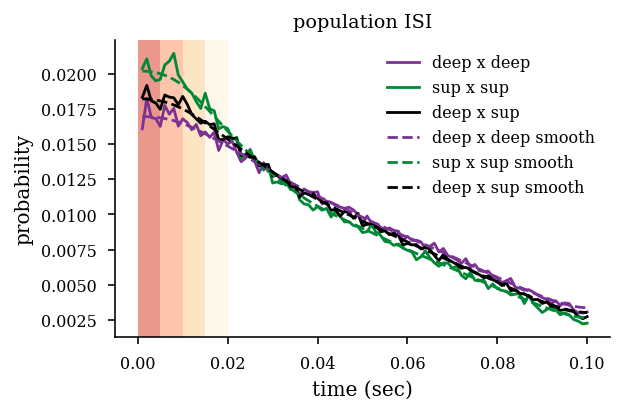

In [411]:
def bin_data(data,xmin=0,xmax=0.100,binwidth=0.001):
    bins = np.arange(xmin,xmax+binwidth,binwidth)

    hist, _ = np.histogram(data,bins=bins)
    hist = hist/hist.sum()
    return hist

df = pd.read_csv(sessions[1])
bin_center = np.arange(0,0.100,0.001) + 0.001

plt.figure(figsize=functions.set_size('thesis', fraction=.75, subplots=(1, 1)), edgecolor='k')
plt.plot(bin_center,bin_data(df.Deep),color="#7b3294",label="deep x deep")
plt.plot(bin_center,bin_data(df.Superficial),color="#008837",label="sup x sup") 
plt.plot(bin_center,bin_data(df.DeepSuperficial),color="black",label="deep x sup") 

ripple_cycle = 1/200
plt.axvspan(0,ripple_cycle, color='#d7301f', alpha=0.5, lw=0)
plt.axvspan(ripple_cycle,ripple_cycle*2, color='#fc8d59', alpha=0.5, lw=0)
plt.axvspan(ripple_cycle*2,ripple_cycle*3, color='#fdcc8a', alpha=0.5, lw=0)
plt.axvspan(ripple_cycle*3,ripple_cycle*4, color='#fef0d9', alpha=0.5, lw=0)

sigma = 5
plt.plot(bin_center,gaussian_filter1d(bin_data(df.Deep), sigma),linestyle="--",color="#7b3294",label="deep x deep smooth")
plt.plot(bin_center,gaussian_filter1d(bin_data(df.Superficial), sigma),linestyle="--",color="#008837",label="sup x sup smooth") 
plt.plot(bin_center,gaussian_filter1d(bin_data(df.DeepSuperficial), sigma),linestyle="--",color="black",label="deep x sup smooth") 

plt.xlabel('time (sec)')
plt.ylabel('probability')
plt.title('population ISI')

# plt.xscale("log")

plt.legend(frameon=False)

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


# plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_gaussian_example.pdf'),dpi=300,bbox_inches='tight')
# plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_gaussian_example.png'),dpi=300,bbox_inches='tight')


# pre task post

In [15]:
df = [df_pre,df_task,df_post]
df = pd.concat(df,keys=['pre', 'task', 'post'])

# Make ratio or pre to task and pre to post

This section can be written more efficiently 

In [16]:
def get_ratio(x1,x2):
    min_val = np.nanmin(np.hstack([x1,x2]))
    if min_val < 0:
        x1 = x1 + np.abs(min_val) + np.finfo(np.float32).eps
        x2 = x2 + np.abs(min_val) + np.finfo(np.float32).eps
    return (x1 - x2) / (x2 + x1)

def get_ratio_var_helper(df,var,cond1,cond2):
     return get_ratio(df.loc[cond1][var].values,df.loc[cond2][var].values)

mean_isi_pre_task =[]
peak_ts_first_cycle_pre_task = []
peak_ts_second_cycle_pre_task = []
peak_val_first_cycle_pre_task = []
peak_val_second_cycle_pre_task = []
peak_val_norm_first_cycle_pre_task = []
peak_val_norm_second_cycle_pre_task = []
first_second_isi_ratio_pre_task = []
mean_isi_pre_post =[]
peak_ts_first_cycle_pre_post = []
peak_ts_second_cycle_pre_post = []
peak_val_first_cycle_pre_post = []
peak_val_second_cycle_pre_post = []
peak_val_norm_first_cycle_pre_post = []
peak_val_norm_second_cycle_pre_post = []
first_second_isi_ratio_pre_post = []

mean_isi_pre_task.append(get_ratio_var_helper(df,"mean_isi","pre","task"))
peak_ts_first_cycle_pre_task.append(get_ratio_var_helper(df,"peak_ts_first_cycle","pre","task"))
peak_ts_second_cycle_pre_task.append(get_ratio_var_helper(df,"peak_ts_second_cycle","pre","task"))
peak_val_first_cycle_pre_task.append(get_ratio_var_helper(df,"peak_val_first_cycle","pre","task"))
peak_val_second_cycle_pre_task.append(get_ratio_var_helper(df,"peak_val_second_cycle","pre","task"))
peak_val_norm_first_cycle_pre_task.append(get_ratio_var_helper(df,"peak_val_norm_first_cycle","pre","task"))
peak_val_norm_second_cycle_pre_task.append(get_ratio_var_helper(df,"peak_val_norm_second_cycle","pre","task"))
first_second_isi_ratio_pre_task.append(get_ratio_var_helper(df,"first_second_isi_ratio","pre","task"))

mean_isi_pre_post.append(get_ratio_var_helper(df,"mean_isi","pre","post"))
peak_ts_first_cycle_pre_post.append(get_ratio_var_helper(df,"peak_ts_first_cycle","pre","post"))
peak_ts_second_cycle_pre_post.append(get_ratio_var_helper(df,"peak_ts_second_cycle","pre","post"))
peak_val_first_cycle_pre_post.append(get_ratio_var_helper(df,"peak_val_first_cycle","pre","post"))
peak_val_second_cycle_pre_post.append(get_ratio_var_helper(df,"peak_val_second_cycle","pre","post"))
peak_val_norm_first_cycle_pre_post.append(get_ratio_var_helper(df,"peak_val_norm_first_cycle","pre","post"))
peak_val_norm_second_cycle_pre_post.append(get_ratio_var_helper(df,"peak_val_norm_second_cycle","pre","post"))
first_second_isi_ratio_pre_post.append(get_ratio_var_helper(df,"first_second_isi_ratio","pre","post"))

isi_metric_ratio = pd.DataFrame()
isi_metric_ratio["basepath"] = np.hstack([np.hstack(df.loc['pre'].basepath),np.hstack(df.loc['pre'].basepath)])
isi_metric_ratio["group"] = np.hstack([np.hstack(df.loc['pre'].group),np.hstack(df.loc['pre'].group)])
isi_metric_ratio['ratio'] = ["pre_task"]*len(np.hstack(df.loc['pre'].basepath)) + ["pre_post"]*len(np.hstack(df.loc['pre'].basepath))
isi_metric_ratio["mean_isi"] = np.hstack([np.hstack(mean_isi_pre_task),np.hstack(mean_isi_pre_post)])
isi_metric_ratio["peak_ts_first_cycle"] = np.hstack([np.hstack(peak_ts_first_cycle_pre_task),np.hstack(peak_ts_first_cycle_pre_post)])
isi_metric_ratio["peak_ts_second_cycle"] = np.hstack([np.hstack(peak_ts_second_cycle_pre_task),np.hstack(peak_ts_second_cycle_pre_post)])
isi_metric_ratio["peak_val_first_cycle"] = np.hstack([np.hstack(peak_val_first_cycle_pre_task),np.hstack(peak_val_first_cycle_pre_post)])
isi_metric_ratio["peak_val_second_cycle"] = np.hstack([np.hstack(peak_val_second_cycle_pre_task),np.hstack(peak_val_second_cycle_pre_post)])
isi_metric_ratio["peak_val_norm_first_cycle"] = np.hstack([np.hstack(peak_val_norm_first_cycle_pre_task),np.hstack(peak_val_norm_first_cycle_pre_post)])
isi_metric_ratio["peak_val_norm_second_cycle"] = np.hstack([np.hstack(peak_val_norm_second_cycle_pre_task),np.hstack(peak_val_norm_second_cycle_pre_post)])
isi_metric_ratio["first_second_isi_ratio"] = np.hstack([np.hstack(first_second_isi_ratio_pre_task),np.hstack(first_second_isi_ratio_pre_post)])

isi_metric_ratio

# first_second_isi_ratio_pre_post

,basepath,group,ratio,mean_isi,peak_ts_first_cycle,peak_ts_second_cycle,peak_val_first_cycle,peak_val_second_cycle,peak_val_norm_first_cycle,peak_val_norm_second_cycle,first_second_isi_ratio
0,Achilles_Achilles_10252013,low_particip,pre_task,0.046690,-0.200000,0.090909,-0.092423,-0.044116,-0.483314,-0.600913,-0.038360
1,Achilles_Achilles_11012013,low_particip,pre_task,-0.039993,-0.333333,-0.066667,-0.082671,-0.092286,-0.474294,-0.566051,0.130724
2,Cicero_Cicero_09012014,low_particip,pre_task,0.022007,0.333333,-0.066667,-0.100272,-0.037728,-0.024050,-0.031821,-0.113874
3,Cicero_Cicero_09102014,low_particip,pre_task,0.038645,-0.600000,-0.166667,0.234909,-0.129673,0.194449,-0.624959,0.186657
4,Cicero_Cicero_09172014,low_particip,pre_task,0.029449,0.142857,0.166667,0.099462,0.178501,0.380976,0.695950,-0.029722
5,Achilles_Achilles_10252013,high_particip,pre_task,0.024981,-0.428571,0.166667,0.017113,-0.012647,-0.129330,-0.121846,-0.006894
6,Achilles_Achilles_11012013,high_particip,pre_task,0.012121,-0.333333,-0.125000,0.014386,-0.017772,-0.076428,-0.280367,-0.005257
7,Cicero_Cicero_09012014,high_particip,pre_task,-0.045051,-0.111111,0.142857,-0.082064,-0.134451,-0.229893,-0.664762,-0.001924
8,Cicero_Cicero_09102014,high_particip,pre_task,0.001256,0.200000,0.076923,-0.017289,-0.038462,-0.029211,-0.209723,0.000504
9,Cicero_Cicero_09172014,high_particip,pre_task,-0.028206,-0.428571,0.166667,-0.019068,0.001087,-0.070121,0.186511,0.000501


# Make ratio box plots

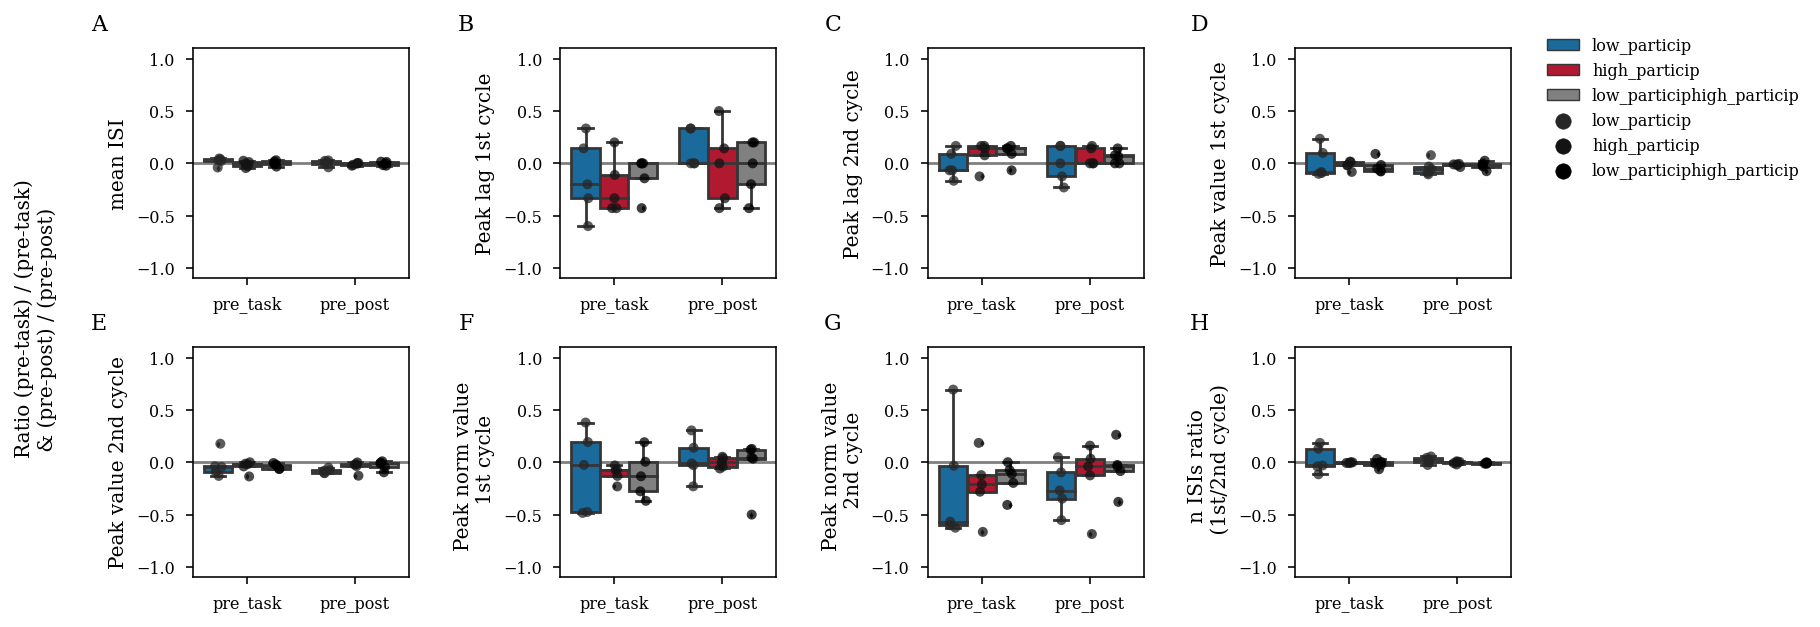

In [55]:
def plot_the_box(df,x,y,group_colors,ax):
    sns.boxplot(x=x, y=y, data=df,fliersize=1,hue="group",
                 ax=ax,hue_order=group_colors.keys())

    sns.stripplot(x=x, y=y, data=df,
                size=5,color="k", linewidth=0,ax=ax,hue="group",
                alpha=.75,dodge=True,hue_order=group_colors.keys())
    ax.axhline(0,color='grey',zorder=-1000)

fig, axs = plt.subplots(2,4, figsize=functions.set_size('thesis', fraction=2, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.7)
axs = axs.ravel()

group_colors = {"deep": '#7b3294',
                'sup': '#008837',
                "deep_sup": "grey"} 

group_colors = {"low_particip": '#0571b0',
                'high_particip': '#ca0020',
                "low_participhigh_particip": "grey"} 

sns.set_palette(sns.color_palette(group_colors.values()))

plot_the_box(isi_metric_ratio,"ratio", "mean_isi",group_colors,axs[0])
plot_the_box(isi_metric_ratio,"ratio", "peak_ts_first_cycle",group_colors,axs[1])
plot_the_box(isi_metric_ratio,"ratio", "peak_ts_second_cycle",group_colors,axs[2])
plot_the_box(isi_metric_ratio,"ratio", "peak_val_first_cycle",group_colors,axs[3])
plot_the_box(isi_metric_ratio,"ratio", "peak_val_second_cycle",group_colors,axs[4])
plot_the_box(isi_metric_ratio,"ratio", "peak_val_norm_first_cycle",group_colors,axs[5])
plot_the_box(isi_metric_ratio,"ratio", "peak_val_norm_second_cycle",group_colors,axs[6])
plot_the_box(isi_metric_ratio,"ratio", "first_second_isi_ratio",group_colors,axs[7])


axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend([],[], frameon=False)
axs[3].legend([],[], frameon=False)
axs[4].legend([],[], frameon=False)
axs[5].legend([],[], frameon=False)
axs[6].legend([],[], frameon=False)
axs[7].legend([],[], frameon=False)

axs[3].legend(bbox_to_anchor=(1.1, 0.01, 0.5, 1.1),frameon=False)

for i in range(8):
    axs[i].set_ylim(-1.1,1.1)
    axs[i].set_xlabel('')

axs[0].set_ylabel("mean ISI")
axs[1].set_ylabel("Peak lag 1st cycle")
axs[2].set_ylabel("Peak lag 2nd cycle")
axs[3].set_ylabel("Peak value 1st cycle")
axs[4].set_ylabel("Peak value 2nd cycle")
axs[5].set_ylabel("Peak norm value \n 1st cycle")
axs[6].set_ylabel("Peak norm value \n 2nd cycle")
axs[7].set_ylabel("n ISIs ratio \n (1st/2nd cycle)")

for i, label in enumerate(('A','B', 'C', 'D','E','F','G','H')):
    axs[i].text(-0.4, 1.15, label, transform=axs[i].transAxes,
      fontsize=11, fontweight='normal', va='top', ha='right')
      
fig.text(0.02, 0.5, 'Ratio (pre-task) / (pre-task) \n & (pre-post) / (pre-post)', va='center', rotation='vertical')

plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_pretaskpost_feature_ratio_low_high_particp.pdf'),dpi=300,bbox_inches='tight')


# Plot all pre task post ISIs

In [48]:
group_colors = {"low_particip": '#0571b0',
                'high_particip': '#ca0020',
                "low_participhigh_particip": "grey"} 

group_colors

{'low_particip': '#0571b0',
 'high_particip': '#ca0020',
 'low_participhigh_particip': 'grey'}

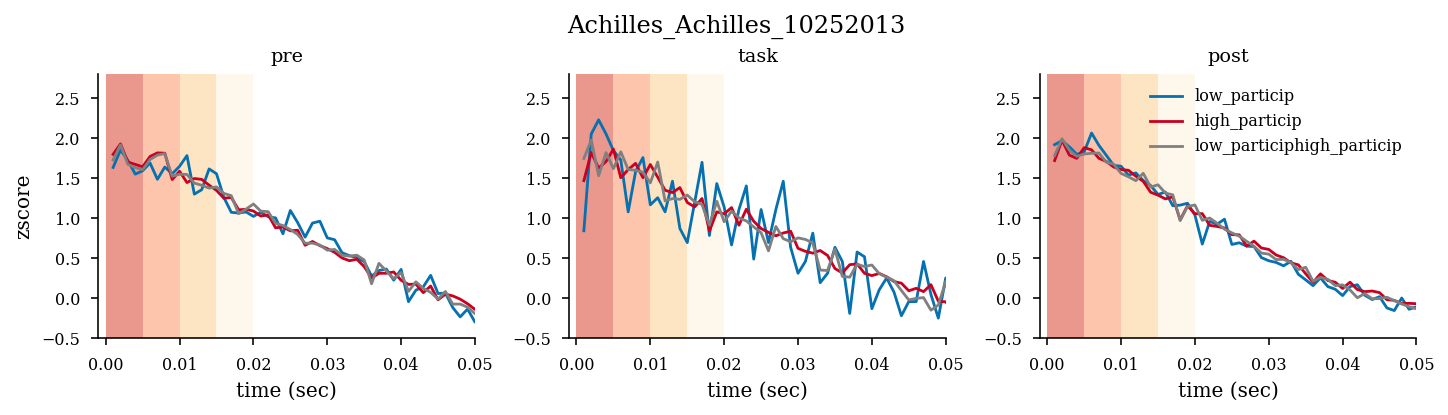

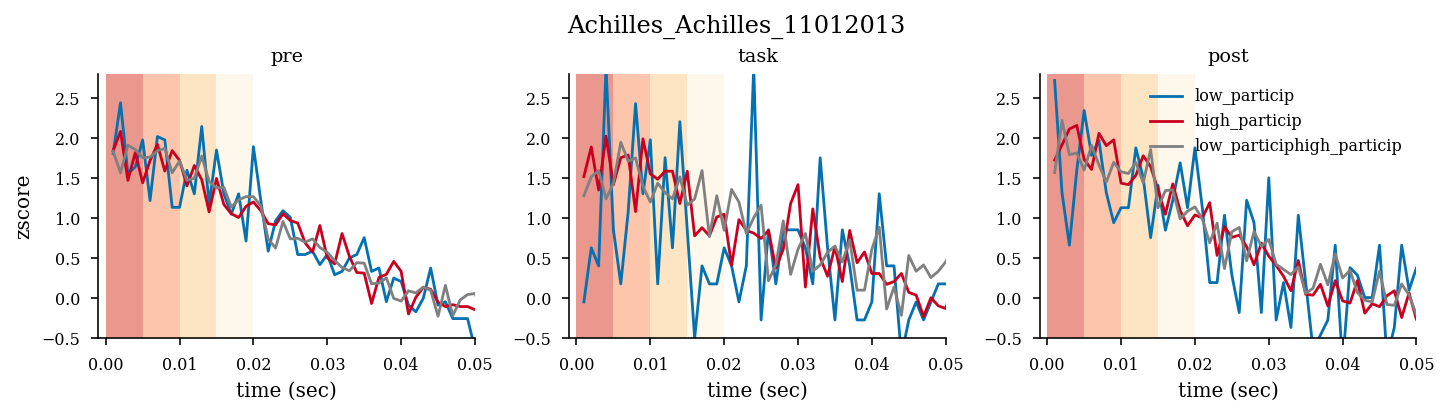

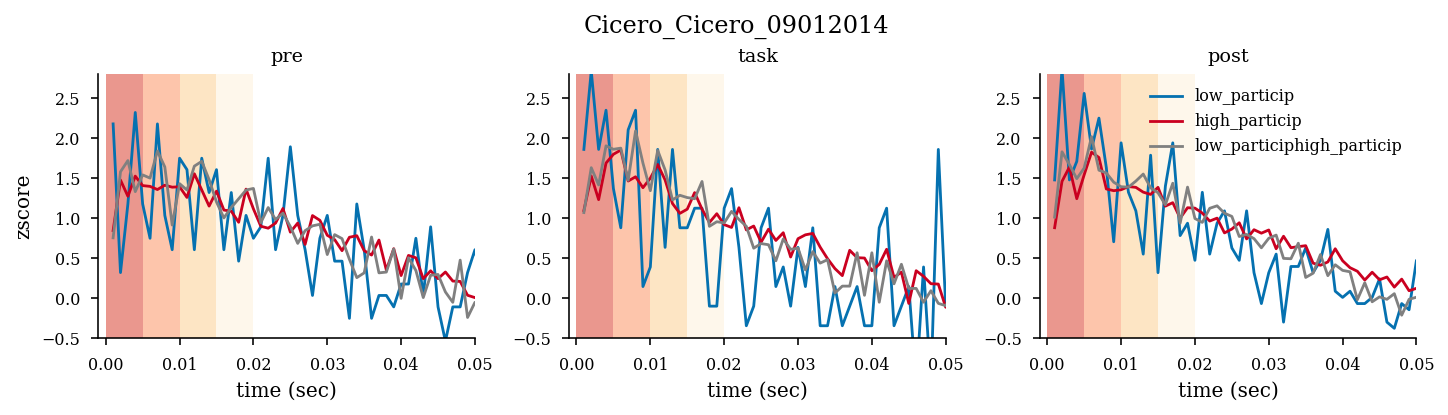

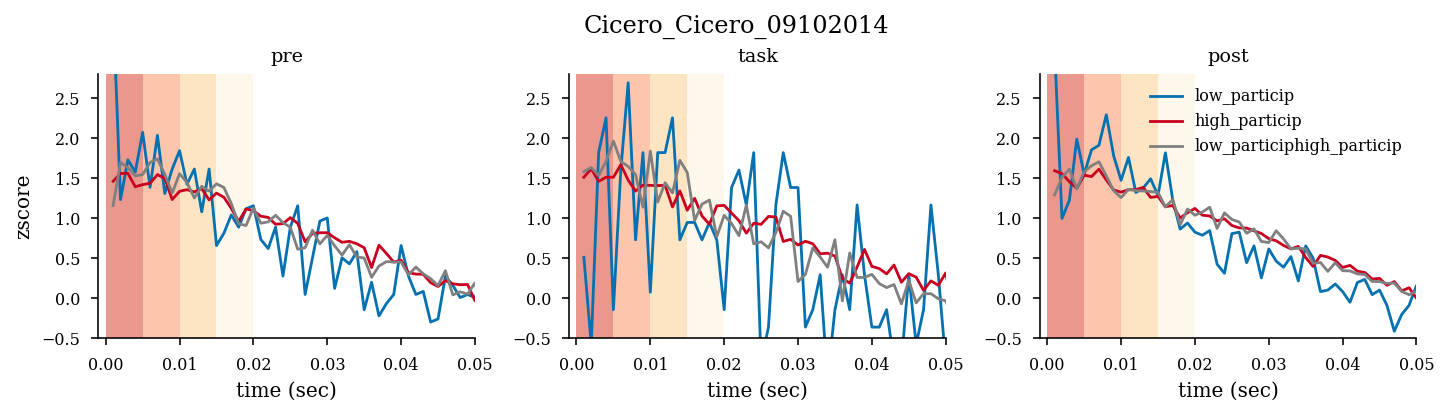

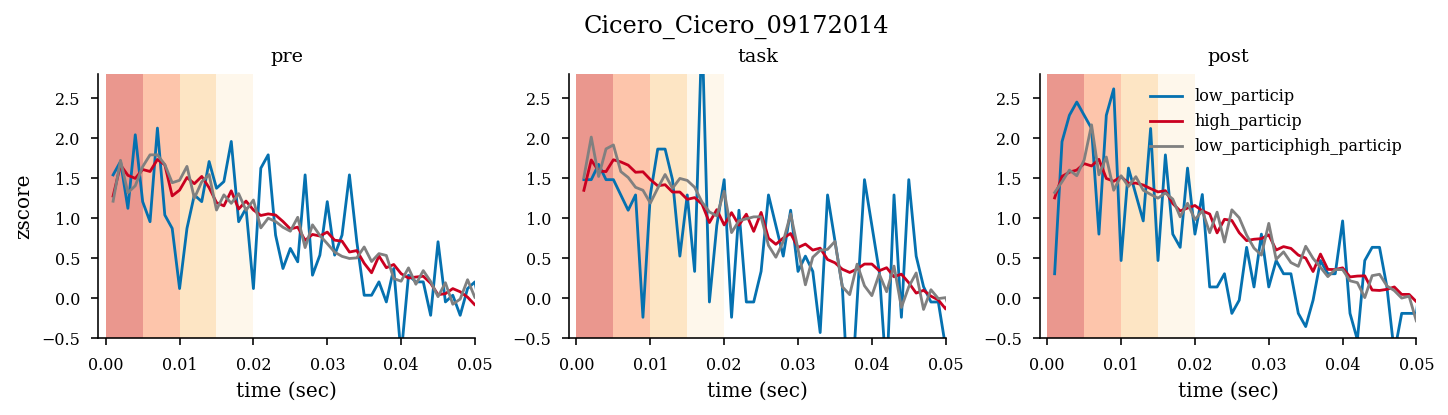

In [52]:
def bin_data(data,xmin=0,xmax=0.100,binwidth=0.001):
    bins = np.arange(xmin,xmax+binwidth,binwidth)

    hist, _ = np.histogram(data,bins=bins)
    hist = hist/hist.sum()
    return hist

def make_ISI_epoch_plot(session,df_pre,all_deep_isi_pre,all_sup_isi_pre,all_deep_sup_isi_pre,
                        all_deep_isi_task,all_sup_isi_task,all_deep_sup_isi_task,
                        all_deep_isi_post,all_sup_isi_post,all_deep_sup_isi_post):

    fig, axs = plt.subplots(1,3,figsize=functions.set_size('thesis', fraction=2, subplots=(1, 3)), edgecolor='k')
    fig.subplots_adjust(hspace = 0, wspace=.25)
    axs = axs.ravel()

    bin_center = np.arange(0,0.100,0.001) + 0.001

    axs[0].plot(bin_center,all_deep_isi_pre[session],color=list(group_colors.values())[0],label=groups[0])
    axs[0].plot(bin_center,all_sup_isi_pre[session],color=list(group_colors.values())[1],label=groups[1]) 
    axs[0].plot(bin_center,all_deep_sup_isi_pre[session],color=list(group_colors.values())[2],label=groups[2]) 

    axs[1].plot(bin_center,all_deep_isi_task[session],color=list(group_colors.values())[0],label=groups[0])
    axs[1].plot(bin_center,all_sup_isi_task[session],color=list(group_colors.values())[1],label=groups[1]) 
    axs[1].plot(bin_center,all_deep_sup_isi_task[session],color=list(group_colors.values())[2],label=groups[2]) 

    axs[2].plot(bin_center,all_deep_isi_post[session],color=list(group_colors.values())[0],label=groups[0])
    axs[2].plot(bin_center,all_sup_isi_post[session],color=list(group_colors.values())[1],label=groups[1]) 
    axs[2].plot(bin_center,all_deep_sup_isi_post[session],color=list(group_colors.values())[2],label=groups[2]) 

    axs[0].set_ylabel('zscore')

    axs[0].set_title('pre')
    axs[1].set_title('task')
    axs[2].set_title('post')

    # axs[0].set_xscale("log")

    axs[2].legend(frameon=False)
    ripple_cycle = 1/200
    for i in range(3):
        axs[i].spines["right"].set_visible(False)
        axs[i].spines["top"].set_visible(False)
        axs[i].set_xlabel('time (sec)')
        axs[i].axvspan(0,ripple_cycle, color='#d7301f', alpha=0.5, lw=0)
        axs[i].axvspan(ripple_cycle,ripple_cycle*2, color='#fc8d59', alpha=0.5, lw=0)
        axs[i].axvspan(ripple_cycle*2,ripple_cycle*3, color='#fdcc8a', alpha=0.5, lw=0)
        axs[i].axvspan(ripple_cycle*3,ripple_cycle*4, color='#fef0d9', alpha=0.5, lw=0)
        axs[i].set_xlim(-.001,0.05)
        axs[i].set_ylim(-0.5,2.8)

    fig.suptitle(df_pre[df_pre.group==groups[0]].basepath.loc[session], fontsize=12, y=1.05)

for session in range(df_pre[df_pre.group==groups[0]].shape[0]):
    make_ISI_epoch_plot(session,df_pre,all_deep_isi_pre,all_sup_isi_pre,all_deep_sup_isi_pre,
                            all_deep_isi_task,all_sup_isi_task,all_deep_sup_isi_task,
                            all_deep_isi_post,all_sup_isi_post,all_deep_sup_isi_post)

    basename = df_pre[df_pre.group==groups[0]].basepath.loc[session]
    plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_pretaskpost_particip'+basename+'.pdf'),dpi=300,bbox_inches='tight')
